## Model Stellar Spectra with 3 Stellar Parameters

### Import

In [1]:
import nbi
import torch
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import uniform
from matplotlib.lines import Line2D

warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing.resource_tracker")

### Set path

In [2]:
data_path = '/stow/weilingfeng/data/apogee/'
save_path = f'{data_path}/nbi_3_params'

### New run or read existing model

In [3]:
new_run = True

### Read Data

In [4]:
# Read simulated spectra
with open(f'{data_path}/simulated_spectra_3_params.pkl', 'rb') as file:
    simulated_spectra = pickle.load(file)

wave = simulated_spectra['wave']
flux = simulated_spectra['flux']
params = np.array([simulated_spectra[_] for _ in ['teff', 'rv', 'vsini']]).T

### Define noise

In [7]:
def noise(x, y):
    rand = np.random.normal(0, 1, size=x.shape[0])

    # let's say x_err is drawn from [0, 0.05]
    x_err = np.random.uniform() * 0.05
    x_noise = x + rand * x_err * x
    return x_noise, y

### Plot an example spectra

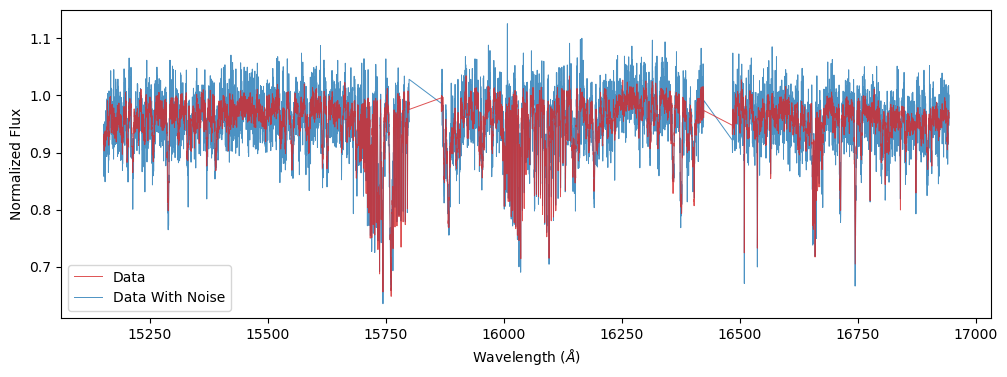

In [12]:
test_idx = 0

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(wave, flux[test_idx], lw=0.7, alpha=0.8, color='C3', label='Data', zorder=2)
ax.plot(wave, noise(flux[test_idx], params[test_idx])[0], lw=0.7, alpha=0.8, label='Data With Noise', zorder=1)
ax.legend()
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Normalized Flux')
plt.show()

### Set prior

In [13]:
prior = {
    'teff':     uniform(loc=2300, scale=7000-2300),  # U(2300, 7000) K
    'rv':       uniform(loc=-200, scale=200-(-200)), # U(-200, 200) km/s
    'vsini':    uniform(loc=0, scale=100)            # U(0, 100) km/s
}

labels = list(prior.keys())
priors = [prior[k] for k in labels]

### Setup nbi and train

In [ ]:
if new_run:
        # clear cuda cache
    torch.cuda.empty_cache()
    
    # the NBI package provides the "ResNet-GRU" network as the default
    # featurizer network for sequential data
    featurizer = {
        'type': 'resnet-gru',
        'norm': 'weight_norm',
        'dim_in': 1,            # Number of channels for input data
        'dim_out': 256,         # Output feature vector dimension
        'dim_conv_max': 512,    # Maximum hidden dimension for CNN
        'depth': 8              # Number of 1D ResNet layers
    }

    flow = {
        'n_dims': len(labels),  # dimension of parameter space
        'flow_hidden': 256,
        'num_cond_inputs': 256,
        'num_blocks': 15,
        'n_mog': 4              # Number of Mixture of Gaussian as base density
    }

    # initialize NBI engine
    engine = nbi.NBI(
        flow=flow,
        featurizer=featurizer,
        # simulator=simulate_spectra,
        priors=priors,
        labels=labels,
        device='cuda',
        path=save_path
    )

    engine.fit(
        x=flux,
        y=params,
        # n_sims=20000,
        n_rounds=1,
        n_epochs=10,
        batch_size=256,
        lr=0.0001,
        early_stop_patience=20,
        noise=noise  # this can also be an array if fixed noise
    )
    
    best_model = engine.best_params
    print(f'Best model saved in {best_model}')
    with open(f'{save_path}/best_model_path.txt', 'w') as file:
        file.write(best_model)

else:
    with open(f'{save_path}/best_model_path.txt', 'r') as file:
        best_model = file.read()
    
    engine = nbi.NBI(
        state_dict=best_model,
        priors=priors,
        labels=labels,
        device='cuda',
        path=save_path
    )


### Predict

In [ ]:
np.random.seed(4)

# draw random parameter from prior
dim = len(wave)

y_pred = engine.predict(flux[0], y_true=params[0], n_samples=12800, corner=True, corner_reweight=True, seed=0)